# Inter-Annotator Agreement Analysis

This notebook calculates inter-annotator agreement metrics for the human annotations of review papers.

**Annotators:**
- Maria
- Yanai

**Task:** Binary classification of whether a paper qualifies as a "review" paper (1) or not (0).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path('../data/annotated')

## 1. Load Annotations

In [2]:
# Load both annotation files
df_yanai = pd.read_csv(DATA_DIR / 'new_data_to_label_YANAI.csv')
df_maria = pd.read_csv(DATA_DIR / 'new_data_to_label_MARIA.csv')

print(f"Yanai annotations: {len(df_yanai)} papers")
print(f"Maria annotations: {len(df_maria)} papers")

Yanai annotations: 200 papers
Maria annotations: 200 papers


In [3]:
# Merge on arxiv_id to get both annotations
df = df_yanai[['arxiv_id', 'YANAI_ANNOTATION']].merge(
    df_maria[['arxiv_id', 'MARIA_ANNOTATION']], 
    on='arxiv_id', 
    how='inner'
)

print(f"Papers with both annotations: {len(df)}")
print(f"\nYanai annotation distribution:")
print(df['YANAI_ANNOTATION'].value_counts())
print(f"\nMaria annotation distribution:")
print(df['MARIA_ANNOTATION'].value_counts())

Papers with both annotations: 200

Yanai annotation distribution:
YANAI_ANNOTATION
0    119
1     81
Name: count, dtype: int64

Maria annotation distribution:
MARIA_ANNOTATION
0    119
1     78
?      3
Name: count, dtype: int64


In [4]:
# Handle uncertain annotations ("?") - treat as negative (0)
df_clean = df.copy()
uncertain_count = (df_clean['MARIA_ANNOTATION'] == '?').sum()
df_clean.loc[df_clean['MARIA_ANNOTATION'] == '?', 'MARIA_ANNOTATION'] = '0'

# Convert to numeric
df_clean['YANAI_ANNOTATION'] = pd.to_numeric(df_clean['YANAI_ANNOTATION'])
df_clean['MARIA_ANNOTATION'] = pd.to_numeric(df_clean['MARIA_ANNOTATION'])

print(f"Total papers: {len(df_clean)}")
if uncertain_count > 0:
    print(f"Note: {uncertain_count} uncertain ('?') annotations treated as NOT REVIEW (0)")

Total papers: 200
Note: 3 uncertain ('?') annotations treated as NOT REVIEW (0)


## 2. Basic Agreement Statistics

In [5]:
# Calculate raw agreement
agreement = (df_clean['YANAI_ANNOTATION'] == df_clean['MARIA_ANNOTATION']).sum()
total = len(df_clean)
raw_agreement = agreement / total

print("="*60)
print("BASIC AGREEMENT STATISTICS")
print("="*60)
print(f"\nTotal papers annotated by both: {total}")
print(f"Papers with matching annotations: {agreement}")
print(f"Raw/Percent Agreement: {raw_agreement:.1%}")

BASIC AGREEMENT STATISTICS

Total papers annotated by both: 200
Papers with matching annotations: 185
Raw/Percent Agreement: 92.5%


In [6]:
# Breakdown of agreement by category
both_review = ((df_clean['YANAI_ANNOTATION'] == 1) & (df_clean['MARIA_ANNOTATION'] == 1)).sum()
both_not_review = ((df_clean['YANAI_ANNOTATION'] == 0) & (df_clean['MARIA_ANNOTATION'] == 0)).sum()
yanai_only = ((df_clean['YANAI_ANNOTATION'] == 1) & (df_clean['MARIA_ANNOTATION'] == 0)).sum()
maria_only = ((df_clean['YANAI_ANNOTATION'] == 0) & (df_clean['MARIA_ANNOTATION'] == 1)).sum()

print(f"\nAgreement breakdown:")
print(f"  Both say REVIEW (1):     {both_review:>4} ({both_review/total:.1%})")
print(f"  Both say NOT REVIEW (0): {both_not_review:>4} ({both_not_review/total:.1%})")
print(f"  Only Yanai says REVIEW:  {yanai_only:>4} ({yanai_only/total:.1%})")
print(f"  Only Maria says REVIEW:  {maria_only:>4} ({maria_only/total:.1%})")


Agreement breakdown:
  Both say REVIEW (1):       72 (36.0%)
  Both say NOT REVIEW (0):  113 (56.5%)
  Only Yanai says REVIEW:     9 (4.5%)
  Only Maria says REVIEW:     6 (3.0%)


## 3. Cohen's Kappa

Cohen's Kappa accounts for agreement that could occur by chance. Values:
- < 0: Less than chance agreement
- 0.01–0.20: Slight agreement
- 0.21–0.40: Fair agreement
- 0.41–0.60: Moderate agreement
- 0.61–0.80: Substantial agreement
- 0.81–1.00: Almost perfect agreement

In [7]:
kappa = cohen_kappa_score(df_clean['YANAI_ANNOTATION'], df_clean['MARIA_ANNOTATION'])

print("="*60)
print("COHEN'S KAPPA")
print("="*60)
print(f"\nCohen's Kappa: {kappa:.3f}")

# Interpret the kappa value
if kappa < 0:
    interpretation = "Less than chance agreement"
elif kappa <= 0.20:
    interpretation = "Slight agreement"
elif kappa <= 0.40:
    interpretation = "Fair agreement"
elif kappa <= 0.60:
    interpretation = "Moderate agreement"
elif kappa <= 0.80:
    interpretation = "Substantial agreement"
else:
    interpretation = "Almost perfect agreement"

print(f"Interpretation: {interpretation}")

COHEN'S KAPPA

Cohen's Kappa: 0.843
Interpretation: Almost perfect agreement


## 4. Scott's Pi

Scott's Pi is similar to Cohen's Kappa but assumes both annotators have the same distribution of ratings (pooled marginals). Useful when annotators are interchangeable.

In [8]:
def scotts_pi(y1, y2):
    """Calculate Scott's Pi for binary annotations."""
    n = len(y1)
    
    # Observed agreement
    p_o = np.mean(y1 == y2)
    
    # Joint proportion for each category (pooled marginals)
    p_1 = (np.sum(y1 == 1) + np.sum(y2 == 1)) / (2 * n)
    p_0 = (np.sum(y1 == 0) + np.sum(y2 == 0)) / (2 * n)
    
    # Expected agreement by chance
    p_e = p_1**2 + p_0**2
    
    # Scott's Pi
    pi = (p_o - p_e) / (1 - p_e)
    
    return pi, p_o, p_e

pi, p_o, p_e = scotts_pi(
    df_clean['YANAI_ANNOTATION'].values, 
    df_clean['MARIA_ANNOTATION'].values
)

print("="*60)
print("SCOTT'S PI")
print("="*60)
print(f"\nObserved agreement (P_o): {p_o:.3f}")
print(f"Expected agreement (P_e): {p_e:.3f}")
print(f"Scott's Pi: {pi:.3f}")

SCOTT'S PI

Observed agreement (P_o): 0.925
Expected agreement (P_e): 0.521
Scott's Pi: 0.843


## 5. Krippendorff's Alpha

Krippendorff's Alpha is a more general reliability coefficient that can handle:
- Multiple annotators
- Missing data
- Various levels of measurement (nominal, ordinal, interval, ratio)

In [9]:
def krippendorff_alpha_binary(y1, y2):
    """Calculate Krippendorff's Alpha for binary annotations with 2 annotators."""
    n = len(y1)
    
    # Create the coincidence matrix
    # Count how many times each pair of values appears
    n_00 = np.sum((y1 == 0) & (y2 == 0))
    n_11 = np.sum((y1 == 1) & (y2 == 1))
    n_01 = np.sum((y1 == 0) & (y2 == 1))
    n_10 = np.sum((y1 == 1) & (y2 == 0))
    
    # Total number of pairable values
    total_pairs = 2 * n  # Each item contributes 2 values
    
    # Observed disagreement
    D_o = (n_01 + n_10) / n
    
    # Expected disagreement
    n_0 = 2 * n_00 + n_01 + n_10  # Total 0s
    n_1 = 2 * n_11 + n_01 + n_10  # Total 1s
    
    D_e = (n_0 * n_1) / (total_pairs * (total_pairs - 1))
    
    # Krippendorff's Alpha
    alpha = 1 - (D_o / D_e) if D_e > 0 else 1
    
    return alpha, D_o, D_e

alpha, D_o, D_e = krippendorff_alpha_binary(
    df_clean['YANAI_ANNOTATION'].values, 
    df_clean['MARIA_ANNOTATION'].values
)

print("="*60)
print("KRIPPENDORFF'S ALPHA")
print("="*60)
print(f"\nObserved disagreement (D_o): {D_o:.3f}")
print(f"Expected disagreement (D_e): {D_e:.3f}")
print(f"Krippendorff's Alpha: {alpha:.3f}")

# Interpretation
if alpha >= 0.80:
    interp = "Good reliability"
elif alpha >= 0.67:
    interp = "Acceptable for tentative conclusions"
else:
    interp = "Low reliability - results should be discarded or treated cautiously"
print(f"Interpretation: {interp}")

KRIPPENDORFF'S ALPHA

Observed disagreement (D_o): 0.075
Expected disagreement (D_e): 0.240
Krippendorff's Alpha: 0.688
Interpretation: Acceptable for tentative conclusions


## 6. Confusion Matrix Visualization

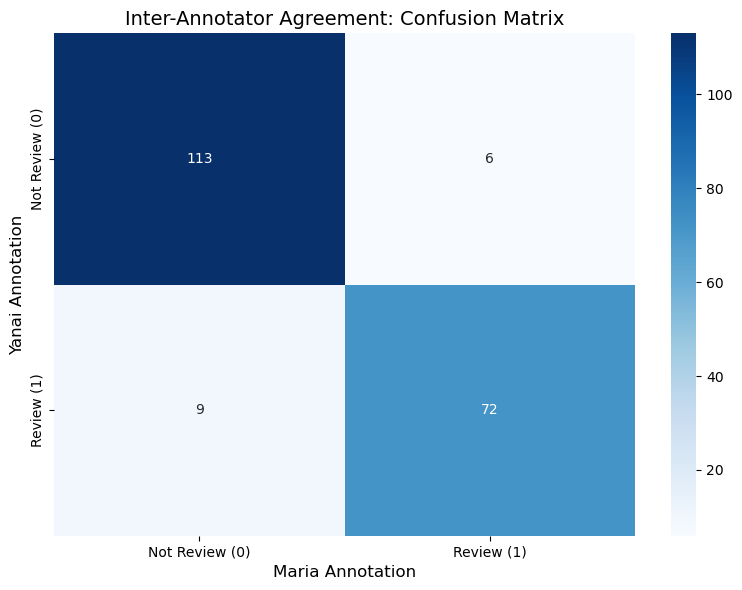


Figure saved to ../figures/annotator_confusion_matrix.png


In [10]:
# Create confusion matrix
cm = confusion_matrix(df_clean['YANAI_ANNOTATION'], df_clean['MARIA_ANNOTATION'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Review (0)', 'Review (1)'],
            yticklabels=['Not Review (0)', 'Review (1)'],
            ax=ax)
ax.set_xlabel('Maria Annotation', fontsize=12)
ax.set_ylabel('Yanai Annotation', fontsize=12)
ax.set_title('Inter-Annotator Agreement: Confusion Matrix', fontsize=14)

plt.tight_layout()
plt.savefig('../figures/annotator_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to ../figures/annotator_confusion_matrix.png")

## 7. Summary Table

In [11]:
print("="*60)
print("SUMMARY OF INTER-ANNOTATOR AGREEMENT METRICS")
print("="*60)
print(f"\n{'Metric':<30} {'Value':>10}")
print("-"*42)
print(f"{'Total papers':<30} {len(df_clean):>10}")
print(f"{'Raw/Percent Agreement':<30} {raw_agreement:>10.1%}")
cohens_label = "Cohen's Kappa"
scotts_label = "Scott's Pi"
kripp_label = "Krippendorff's Alpha"
print(f"{cohens_label:<30} {kappa:>10.3f}")
print(f"{scotts_label:<30} {pi:>10.3f}")
print(f"{kripp_label:<30} {alpha:>10.3f}")
print("-"*42)

# Save summary to CSV
summary_df = pd.DataFrame({
    'Metric': ['Total Papers', 'Raw Agreement', "Cohen's Kappa", "Scott's Pi", "Krippendorff's Alpha"],
    'Value': [len(df_clean), f"{raw_agreement:.3f}", f"{kappa:.3f}", f"{pi:.3f}", f"{alpha:.3f}"]
})
summary_df.to_csv('../data/results/inter_annotator_agreement.csv', index=False)
print(f"\nSummary saved to ../data/results/inter_annotator_agreement.csv")

SUMMARY OF INTER-ANNOTATOR AGREEMENT METRICS

Metric                              Value
------------------------------------------
Total papers                          200
Raw/Percent Agreement               92.5%
Cohen's Kappa                       0.843
Scott's Pi                          0.843
Krippendorff's Alpha                0.688
------------------------------------------

Summary saved to ../data/results/inter_annotator_agreement.csv


## 8. Disagreement Analysis

Examine the papers where annotators disagreed to understand patterns in disagreement.

In [12]:
# Get papers with disagreement
disagreements = df_clean[df_clean['YANAI_ANNOTATION'] != df_clean['MARIA_ANNOTATION']].copy()

# Add paper details
disagreements = disagreements.merge(
    df_maria[['arxiv_id', 'title', 'abstract']], 
    on='arxiv_id'
)

print(f"Total disagreements: {len(disagreements)}")
print(f"\nDisagreement breakdown:")
print(f"  Yanai=1, Maria=0: {len(disagreements[disagreements['YANAI_ANNOTATION'] == 1])}")
print(f"  Yanai=0, Maria=1: {len(disagreements[disagreements['MARIA_ANNOTATION'] == 1])}")

Total disagreements: 15

Disagreement breakdown:
  Yanai=1, Maria=0: 9
  Yanai=0, Maria=1: 6


In [16]:
# Display disagreement cases
print("\n" + "="*60)
print("PAPERS WITH ANNOTATOR DISAGREEMENT")
print("="*60)

for i, row in disagreements.iterrows():
    print(f"\n--- {row['arxiv_id']} ---")
    print(f"Title: {row['title']}")
    print(f"Yanai: {int(row['YANAI_ANNOTATION'])} | Maria: {int(row['MARIA_ANNOTATION'])}")
    # Truncate abstract for display
    abstract = ' '.join(row['abstract'].split())
    print(f"Abstract: {abstract}")


PAPERS WITH ANNOTATOR DISAGREEMENT

--- 2101.05869 ---
Title: Technical Report: Rapid Reviews on Engineering of Internet of Things
  Software Systems
Yanai: 1 | Maria: 0
Abstract: We conducted a set of Rapid Reviews to characterize Internet of Things facets. We formatted a generic meta-protocol that was instantiated for each of the six facets presented (Connectivity, Things, Behavior, Smartness, Interactivity, and Environment)and considering the issue of Security, one of the most important and frequent challenges in the context of IoT. The meta-protocol is detailed and the results of each review are presented.

--- 2101.11775 ---
Title: Moral and Social Ramifications of Autonomous Vehicles
Yanai: 1 | Maria: 0
Abstract: Autonomous Vehicles (AVs) raise important social and ethical concerns, especially about accountability, dignity, and justice. We focus on the specific concerns arising from how AV technology will affect the lives and livelihoods of professional and semi-professional dri

## 9. Prevalence and Bias Analysis

In [14]:
# Calculate prevalence (base rate of positive class)
yanai_prevalence = df_clean['YANAI_ANNOTATION'].mean()
maria_prevalence = df_clean['MARIA_ANNOTATION'].mean()
combined_prevalence = (yanai_prevalence + maria_prevalence) / 2

print("="*60)
print("PREVALENCE AND BIAS ANALYSIS")
print("="*60)
print(f"\nPrevalence of 'review' label:")
print(f"  Yanai: {yanai_prevalence:.1%}")
print(f"  Maria: {maria_prevalence:.1%}")
print(f"  Combined average: {combined_prevalence:.1%}")

# Bias index (difference in marginal distributions)
bias = abs(yanai_prevalence - maria_prevalence)
print(f"\nBias (|Yanai - Maria| prevalence): {bias:.3f}")

# Prevalence index
prevalence_index = abs(combined_prevalence - 0.5)
print(f"Prevalence index (|avg - 0.5|): {prevalence_index:.3f}")
print("\nNote: High prevalence index can make kappa misleadingly low even with high agreement.")

PREVALENCE AND BIAS ANALYSIS

Prevalence of 'review' label:
  Yanai: 40.5%
  Maria: 39.0%
  Combined average: 39.8%

Bias (|Yanai - Maria| prevalence): 0.015
Prevalence index (|avg - 0.5|): 0.102

Note: High prevalence index can make kappa misleadingly low even with high agreement.
